# Sero status
Select an effective cut off for seropositive or seronegative. Try using N and S only, and N, S and RBD. A decent number of the reference samples have no rbd (68 out of 232)

## Data preprocessing
The data has seperate columns for positive and control samples. Sort this out.

> Note , those are real world unselected PCR+ samples which may be at different times of infections (hence some low anti-S) ~~or with impaired immunocompetency~~ (immuno compromised individuals were removed)

> Thanks for sending this over Rainer,
I have a couple of questions
What's the difference between the p columns and the c columns? Are they different versions of the same assays?
Which type are the other staff samples?
What do the different sample name codes mean? Which are positive and negative?
I assume that the "COVID SAMPLE"s and the "COV" samples are positive but is the letter in brackets afterwards important (S, R, E, or L)?
Then there are 3 other types that aren't so clear: HC, CT, and pat?
Any light you could shed on this would be great, thanks,
David


>P = Patient, C= control (either HC or CT, or Lab) > columns I to M
All patient samples (most labelled with cov or covid or pat) are PCR + > columns C to G
Please disregard S, R, E, or L

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

%load_ext rpy2.ipython
from rpy2.robjects import r

In [2]:
os.chdir("/home/david/linux_work/coronavirus_2020/papworth/staff_analysis/data")

In [3]:
covid_ref = pd.read_csv("rawdata/covid_pos_neg_reference_samples2.csv")
#remove NAs
covid_ref = covid_ref.dropna(axis=0, subset=['s','n'])

In [4]:
# Counts of control and patient samples in the SVM training data
covid_ref.status.value_counts()

control    126
patient    101
Name: status, dtype: int64

In [5]:
plt.rcParams['figure.figsize'] = [9, 6]

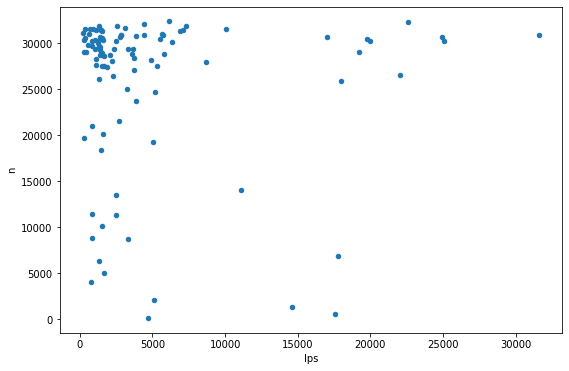

In [6]:
covid_ref[covid_ref.status == 'patient'].plot('lps','n','scatter')

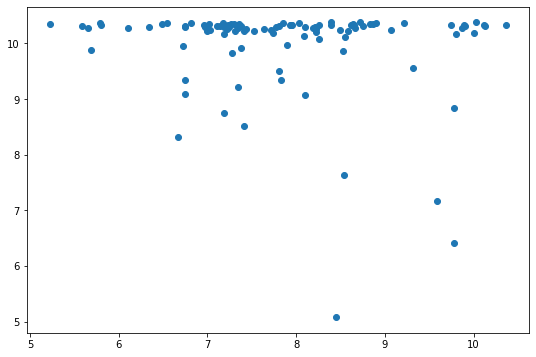

In [7]:
p = covid_ref[covid_ref.status == 'patient']
plt.scatter(np.log(p.lps), np.log(p.n))

In [8]:
p.sort_values('n')

,subject,status,bsa,blank,n,s,rbd,lps
19,COV 76,patient,71.0,72.3,159.8,104.5,NaN,4689.0
31,COV 22,patient,10.5,25.0,609.0,636.5,NaN,17580.0
10,COV 34,patient,71.0,75.3,1304.5,135.0,NaN,14616.3
1,COV 49,patient,147.5,176.8,2079.5,5922.5,NaN,5139.3
28,COV 19,patient,5.5,12.0,4106.0,2079.8,NaN,783.3
...,...,...,...,...,...,...,...,...
35,COV 271,patient,NaN,NaN,31878.3,30744.5,19529.5,7313.3
40,COV 510,patient,NaN,NaN,31899.0,31190.0,26790.3,2568.0
33,COV 258,patient,NaN,NaN,32110.3,29893.5,25571.5,4424.3
34,COV 269,patient,NaN,NaN,32272.0,31665.0,28497.8,22621.5


In [9]:
# center and scale
scaler = preprocessing.StandardScaler()

#Scaled data
scd = scaler.fit_transform(covid_ref[['s','n']])

#Encode status numerically
y = covid_ref.status == 'patient'
y = y.astype(int).values

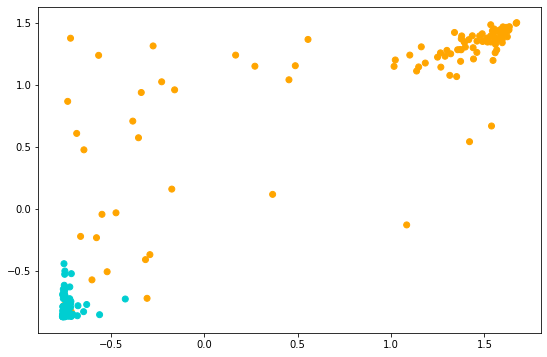

In [10]:
colours = {'patient':'orange', 'control':'darkturquoise'}
col_convert = np.vectorize(lambda x: 'grey' if pd.isnull(x) else colours[x])
plt.scatter(scd[:,0], scd[:,1], c=col_convert(covid_ref.status))

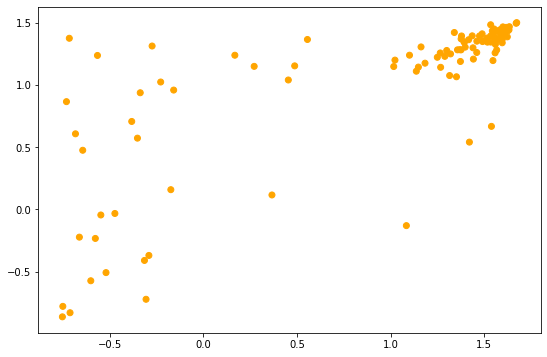

In [11]:
plt.scatter(scd[covid_ref.status == "patient", 0], scd[covid_ref.status == "patient", 1],
            c=col_convert(covid_ref.loc[covid_ref.status=="patient", "status"]))

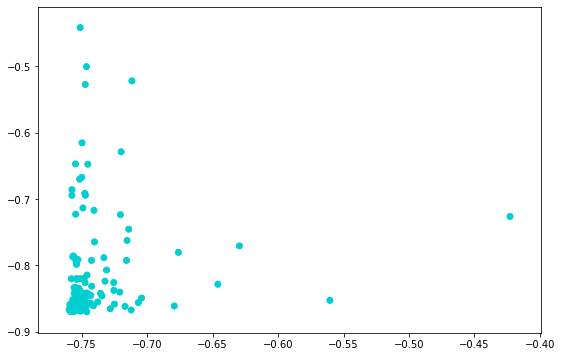

In [12]:
plt.scatter(scd[covid_ref.status == "control", 0], scd[covid_ref.status == "control", 1],
            c=col_convert(covid_ref.loc[covid_ref.status=="control", "status"]))

Text(-5000, 32000, 'C)')

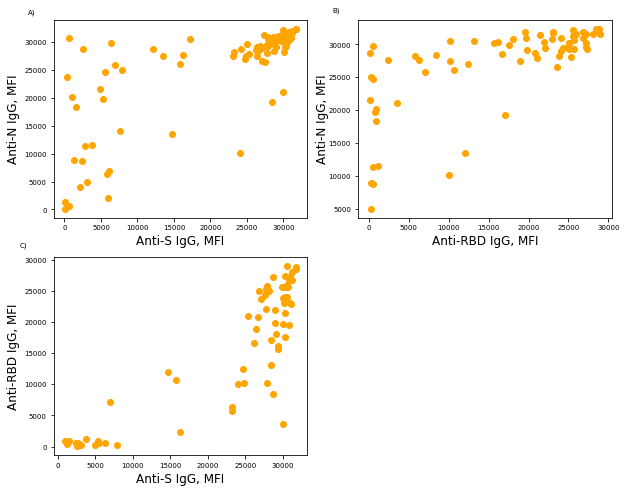

In [13]:
plt.rcParams['figure.figsize'] = [10,8]
plt.rc("font", size=7)
plt.rc("axes", labelsize=12)

pat = covid_ref[covid_ref.status=='patient']

plt.subplot(221)
plt.scatter(pat.s, pat.n, c='orange')
plt.xlabel('Anti-S IgG, MFI')
plt.ylabel('Anti-N IgG, MFI')
plt.text(-5000,35000,"A)")


plt.subplot(222)
plt.scatter(pat.rbd, pat.n, c='orange')
plt.xlabel('Anti-RBD IgG, MFI')
plt.ylabel('Anti-N IgG, MFI', labelpad=0)
plt.text(-4500,35000,"B)")

plt.subplot(223)
plt.scatter(pat.s, pat.rbd, c='orange')
plt.xlabel('Anti-S IgG, MFI')
plt.ylabel('Anti-RBD IgG, MFI')
plt.text(-5000,32000,"C)")

# plt.savefig("figure_s1.jpg", dpi=300, format="jpg")

In [14]:
#Including missing values of RBD
covid_ref.status.value_counts()

control    126
patient    101
Name: status, dtype: int64

In [15]:
skf = StratifiedKFold(n_splits=5)

# Indices
indi = []

for train_i, test_i in skf.split(scd, y):
    indi.append((train_i, test_i))

## Classify using N and S
### K nearest neighbors

In [16]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(scd, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

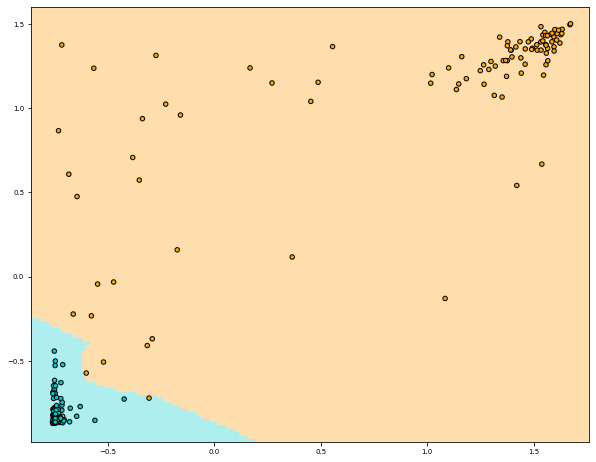

In [17]:
#Step size in the mesh
h=0.02

colourmap = ListedColormap(['darkturquoise', 'orange'])
colourmap2 = ListedColormap(['paleturquoise', 'navajowhite'])

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = scd[:, 0].min() - 0.1, scd[:, 0].max() + 0.1
y_min, y_max = scd[:, 1].min() - 0.11, scd[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=colourmap2)

# Plot also the training points
plt.scatter(scd[:, 0], scd[:, 1], c=y, cmap=colourmap,
            edgecolor='k', s=20)
# plt.xlim(xx.min(), xx.max())
# plt.ylim(yy.min(), yy.max())
# # plt.title("3-Class classification (k = %i, weights = '%s')"
# #           % (n_neighbors, weights))

plt.show()

In [18]:
sensitivity = []
specificity = []

# Cross validation
for i in indi:
    mod = KNeighborsClassifier(n_neighbors=3)
    mod.fit(scd[i[0]], y[i[0]])

    # prediction is true positive
    tp = np.sum((mod.predict(scd[i[1]]) == y[i[1]]) & (mod.predict(scd[i[1]]) == 1))
    #False negatives
    fn = np.sum((mod.predict(scd[i[1]]) != y[i[1]]) & (mod.predict(scd[i[1]]) == 0))

    # prediction is true negative
    tn = np.sum((mod.predict(scd[i[1]]) == y[i[1]]) & (mod.predict(scd[i[1]]) == 0))
    #False positives
    fp = np.sum((mod.predict(scd[i[1]]) != y[i[1]]) & (mod.predict(scd[i[1]]) == 1))

    sensitivity.append(tp/(tp+fn))
    specificity.append(tn/(tn+fp))
    
#     print(mod.score(scd[i[1]], y[i[1]]))

print(np.mean(specificity))
print(np.mean(sensitivity))

1.0
0.9414285714285715


### Linear SVM

In [19]:
svm = LinearSVC()
svm.fit(scd, y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

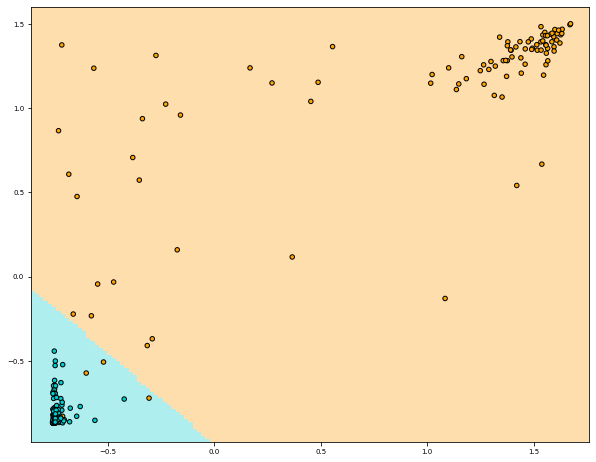

In [20]:
#Step size in the mesh
h=0.02

colourmap = ListedColormap(['darkturquoise', 'orange'])
colourmap2 = ListedColormap(['paleturquoise', 'navajowhite'])

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = scd[:, 0].min() - 0.1, scd[:, 0].max() + 0.1
y_min, y_max = scd[:, 1].min() - 0.11, scd[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=colourmap2)

# Plot also the training points
plt.scatter(scd[:, 0], scd[:, 1], c=y, cmap=colourmap,
            edgecolor='k', s=20)
# plt.xlim(xx.min(), xx.max())
# plt.ylim(yy.min(), yy.max())
# # plt.title("3-Class classification (k = %i, weights = '%s')"
# #           % (n_neighbors, weights))

plt.show()

In [36]:
sensitivity = []
specificity = []

# Cross validation
for i in indi:
    mod = LinearSVC()
    mod.fit(scd[i[0]], y[i[0]])

    # prediction is true positive
    tp = np.sum((mod.predict(scd[i[1]]) == y[i[1]]) & (mod.predict(scd[i[1]]) == 1))
    #False negatives
    fn = np.sum((mod.predict(scd[i[1]]) != y[i[1]]) & (mod.predict(scd[i[1]]) == 0))

    # prediction is true negative
    tn = np.sum((mod.predict(scd[i[1]]) == y[i[1]]) & (mod.predict(scd[i[1]]) == 0))
    #False positives
    fp = np.sum((mod.predict(scd[i[1]]) != y[i[1]]) & (mod.predict(scd[i[1]]) == 1))

    sensitivity.append(tp/(tp+fn))
    specificity.append(tn/(tn+fp))
    
#     print(mod.score(scd[i[1]], y[i[1]]))

    
print(np.mean(specificity))
print(np.mean(sensitivity))

1.0
0.9314285714285713


### RBF svm

In [22]:
svc = SVC()
svc.fit(scd, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

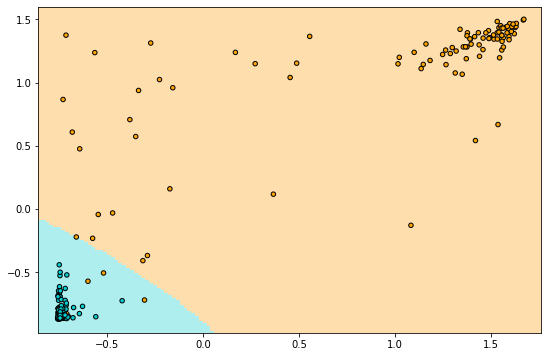

In [23]:
#Step size in the mesh
h=0.02

colourmap = ListedColormap(['darkturquoise', 'orange'])
colourmap2 = ListedColormap(['paleturquoise', 'navajowhite'])

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = scd[:, 0].min() - 0.1, scd[:, 0].max() + 0.1
y_min, y_max = scd[:, 1].min() - 0.11, scd[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=colourmap2)

# Plot also the training points
plt.scatter(scd[:, 0], scd[:, 1], c=y, cmap=colourmap,
            edgecolor='k', s=20)
# plt.xlim(xx.min(), xx.max())
# plt.ylim(yy.min(), yy.max())
# # plt.title("3-Class classification (k = %i, weights = '%s')"
# #           % (n_neighbors, weights))

plt.show()

In [24]:
sensitivity = []
specificity = []

# Cross validation
for i in indi:
    mod = SVC()
    mod.fit(scd[i[0]], y[i[0]])

    # prediction is true positive
    tp = np.sum((mod.predict(scd[i[1]]) == y[i[1]]) & (mod.predict(scd[i[1]]) == 1))
    #False negatives
    fn = np.sum((mod.predict(scd[i[1]]) != y[i[1]]) & (mod.predict(scd[i[1]]) == 0))

    # prediction is true negative
    tn = np.sum((mod.predict(scd[i[1]]) == y[i[1]]) & (mod.predict(scd[i[1]]) == 0))
    #False positives
    fp = np.sum((mod.predict(scd[i[1]]) != y[i[1]]) & (mod.predict(scd[i[1]]) == 1))

    sensitivity.append(tp/(tp+fn))
    specificity.append(tn/(tn+fp))

#     print(mod.score(scd[i[1]], y[i[1]]))
    
print(np.mean(specificity))
print(np.mean(sensitivity))

1.0
0.9123809523809523


## Does RBD improve classification?
In this dataset including RBD does improve classification, however, it seemst that this improvement is driven by RBD providing more information than S and dropping S does not seem to reduce classification accuracy.

In [19]:
covid_refb = pd.read_csv("rawdata/covid_pos_neg_reference_samples2.csv")
#remove NAs
covid_refb = covid_refb.dropna(axis=0, subset=['s','n', 'rbd'])

In [20]:
# center and scale
scalerb = preprocessing.StandardScaler()

#Scaled data
scdb = scalerb.fit_transform(covid_refb[['s','n','rbd']])

#Encode status numerically
yb = covid_refb.status == 'patient'
yb = yb.astype(int).values

In [21]:
scalerb.mean_

array([10033.92121212, 11894.03212121,  7029.15878788])

Text(0, 0.5, 'RBD')

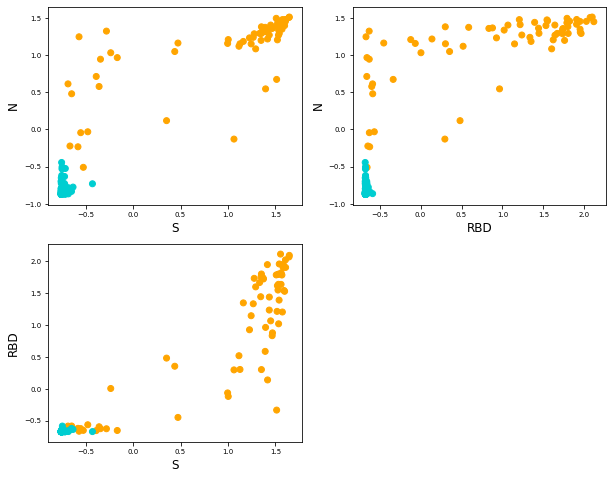

In [22]:
colours = {'patient':'orange', 'control':'darkturquoise'}
col_convert = np.vectorize(lambda x: 'grey' if pd.isnull(x) else colours[x])

plt.subplot(221)
plt.scatter(scdb[:,0], scdb[:,1], c=col_convert(covid_refb.status))
plt.xlabel('S')
plt.ylabel('N')

plt.subplot(222)
plt.scatter(scdb[:,2], scdb[:,1], c=col_convert(covid_refb.status))
plt.xlabel('RBD')
plt.ylabel('N')

plt.subplot(223)
plt.scatter(scdb[:,0], scdb[:,2], c=col_convert(covid_refb.status))
plt.xlabel('S')
plt.ylabel('RBD')

In [23]:
covid_refb.status.value_counts()

control    95
patient    70
Name: status, dtype: int64

In [24]:
skfb = StratifiedKFold(n_splits=5)

# Indices
indib = []

for train_i, test_i in skfb.split(scdb, yb):
    indib.append((train_i, test_i))

### Linear SVM

In [25]:
svmb = LinearSVC()
svmb.fit(scdb, yb)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [26]:
sensitivity = []
specificity = []

# Cross validation
for i in indib:
    mod = LinearSVC()
    mod.fit(scdb[i[0]], yb[i[0]])

    # prediction is true positive
    tp = np.sum((mod.predict(scdb[i[1]]) == yb[i[1]]) & (mod.predict(scdb[i[1]]) == 1))
    #False negatives
    fn = np.sum((mod.predict(scdb[i[1]]) != yb[i[1]]) & (mod.predict(scdb[i[1]]) == 0))

    # prediction is true negative
    tn = np.sum((mod.predict(scdb[i[1]]) == yb[i[1]]) & (mod.predict(scdb[i[1]]) == 0))
    #False positives
    fp = np.sum((mod.predict(scdb[i[1]]) != yb[i[1]]) & (mod.predict(scdb[i[1]]) == 1))

    sensitivity.append(tp/(tp+fn))
    specificity.append(tn/(tn+fp))
    
#     print(mod.score(scd[i[1]], y[i[1]]))

    
print(np.mean(specificity))
print(np.mean(sensitivity))

1.0
0.9714285714285715


In [27]:
# average rbd to use for the cutoff
df = pd.DataFrame(scdb, columns=['s','n','r'])
df['status'] = yb
df.groupby('status').mean()

,s,n,r
status,,,
0,-0.739906,-0.812827,-0.669247
1,1.004158,1.103122,0.908264


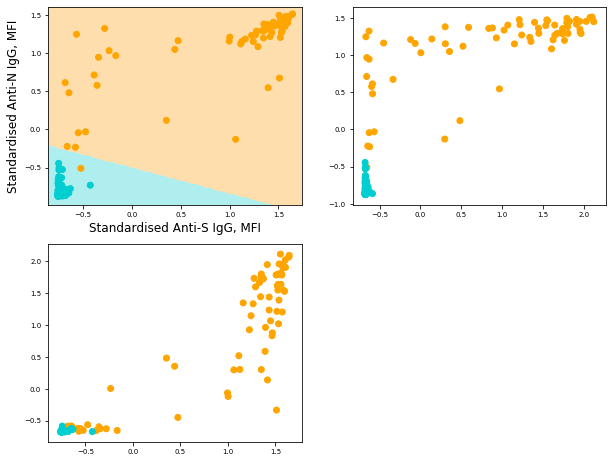

In [77]:
#Step size in the mesh
h=0.01

plt.rcParams['figure.figsize'] = [10,8]
plt.rc("font", size=7)
plt.rc("axes", labelsize=12)

colourmap = ListedColormap(['darkturquoise', 'orange'])
colourmap2 = ListedColormap(['paleturquoise', 'navajowhite'])

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = scdb[:, 0].min() - 0.1, scdb[:, 0].max() + 0.1
y_min, y_max = scdb[:, 1].min() - 0.11, scdb[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = svmb.predict(np.c_[xx.ravel(), yy.ravel(), np.full(xx.ravel().shape, -0.7)])
# Put the result into a color plot
Z = Z.reshape(xx.shape)
Zr = Z



plt.figure()

plt.subplot(221)
plt.pcolormesh(xx, yy, Zr, cmap=colourmap2)
# Plot also the training points
plt.scatter(scdb[:, 0], scdb[:, 1], c=yb, cmap=colourmap)
plt.xlabel('Standardised Anti-S IgG, MFI')
plt.ylabel('Standardised Anti-N IgG, MFI')

plt.subplot(222)
# plt.pcolormesh(xx, yy, Z, cmap=colourmap2)
# Plot also the training points
plt.scatter(scdb[:, 2], scdb[:, 1], c=yb, cmap=colourmap)

plt.subplot(223)
# plt.pcolormesh(xx, yy, Z, cmap=colourmap2)
# Plot also the training points
plt.scatter(scdb[:, 0], scdb[:, 2], c=yb, cmap=colourmap)

plt.show()

In [90]:
# plt.rcParams['figure.figsize'] = [10,8]
# plt.rc("font", size=7)
# plt.rc("axes", labelsize=12)

# pat = covid_ref[covid_ref.status=='patient']

# plt.subplot(221)
# plt.scatter(pat.s, pat.n, c='orange')
# plt.xlabel('Anti-S IgG, MFI')
# plt.ylabel('Anti-N IgG, MFI')
# plt.text(-5000,35000,"A)")


# plt.subplot(222)
# plt.scatter(pat.rbd, pat.n, c='orange')
# plt.xlabel('Anti-RBD IgG, MFI')
# plt.ylabel('Anti-N IgG, MFI', labelpad=0)
# plt.text(-4500,35000,"B)")

# plt.subplot(223)
# plt.scatter(pat.s, pat.rbd, c='orange')
# plt.xlabel('Anti-S IgG, MFI')
# plt.ylabel('Anti-RBD IgG, MFI')
# plt.text(-5000,32000,"C)")

# colourmap = ListedColormap(['darkturquoise', 'orange'])
# colourmap2 = ListedColormap(['paleturquoise', 'navajowhite'])

# #Geneate Z on the original scale
# # Plot the decision boundary. For that, we will assign a color to each
# # point in the mesh [x_min, x_max]x[y_min, y_max].
# x_min, x_max = scalerb.inverse_transform(scdb)[:, 0].min() - 1000, scalerb.inverse_transform(scdb)[:, 0].max() + 1000
# y_min, y_max = scalerb.inverse_transform(scdb)[:, 1].min() - 1000, scalerb.inverse_transform(scdb)[:, 1].max() + 1000
# xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max - x_min)/Z.shape[1]),
#                      np.arange(y_min, y_max, (y_max - y_min)/Z.shape[0]))

# #Uses the Z generated above
# # Z = svmb.predict(np.c_[xx.ravel(), yy.ravel(), np.full(xx.ravel().shape, -0.7)])

# # Put the result into a color plot
# # Z = Z.reshape(xx.shape)
# plt.subplot(224)
# # fig = plt.figure()
# plt.pcolormesh(xx, yy, Z, cmap=colourmap2)


# # Plot also the training points
# plt.scatter(scaler.inverse_transform(scd)[:, 0], scaler.inverse_transform(scd)[:, 1], c=y, cmap=colourmap)
# plt.xlabel('Anti-S IgG, MFI')
# plt.ylabel('Anti-N IgG, MFI')
# plt.text(-5000,35000,"D)")

## Categorise samples
Using the linear SVM categorise all staff samples. This model was chosen for its high sensitivity (no false positives) with little reduction in true negative rate. Looking at the distribution of staff data however suggests that the N range of negative samples may be higher than expected. This could be because the staff may have been infected months ago and their N response has dropped off.

In [49]:
from joblib import dump
dump(scalerb, "scaler.joblib")
dump(svmb, "linear_svmb.joblib")

['linear_svmb.joblib']

In [50]:
staf = pd.read_csv("staff_demographic_antibodies.csv")

#Scale staf based on the covid_ref data
#Replace na values with -999 so svm runs
sc_staf = scalerb.transform(staf[['s','n','rbd']].fillna(-999))

#Classify the scaled staf data using the svm model fit to all of the covid_ref data
staf['sero_svm'] = svmb.predict(sc_staf)

#Where s or n is na the prediction should be too
staf.loc[staf.s.isnull() | staf.n.isnull() | staf.rbd.isnull(), 'sero_svm'] = np.nan

In [51]:
#Number of samples with RBD, S, and N bindings
print(staf.sero_svm.value_counts().sum())
# Number of negative and positive cases
staf.sero_svm.value_counts()

493


0.0    423
1.0     70
Name: sero_svm, dtype: int64

In [52]:
stafsymp = pd.read_csv("staff_demographic_symptoms_antibodies.csv")

#Scale staf based on the covid_ref data
#Replace na values with -999 so svm runs
sc_stafsymp = scalerb.transform(stafsymp[['s','n','rbd']].fillna(-999))

#Classify the scaled staf data using the svm model fit to all of the covid_ref data
stafsymp['sero_svm'] = svmb.predict(sc_stafsymp)

#Where s or n is na the prediction should be too
stafsymp.loc[stafsymp.s.isnull() | stafsymp.n.isnull() | stafsymp.rbd.isnull(), 'sero_svm'] = np.nan

In [53]:
plt.rc('axes')

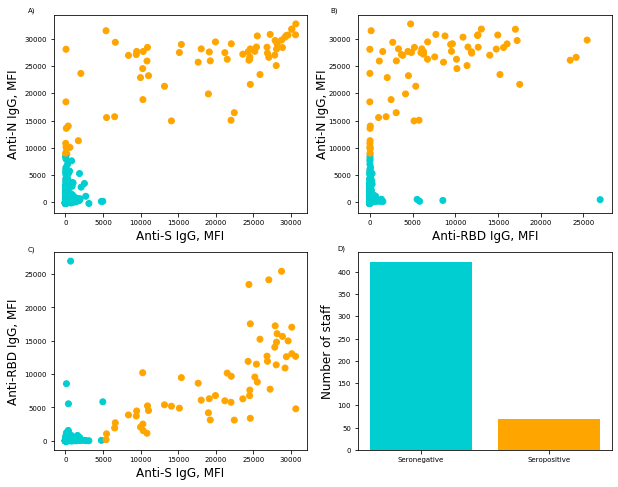

In [54]:
plt.rcParams['figure.figsize'] = [10,8]
plt.rc("font", size=7)
plt.rc("axes", labelsize=12)

colours = {1:'orange', 0:'darkturquoise'}
col_convert = np.vectorize(lambda x: 'grey' if pd.isnull(x) else colours[x])

fig = plt.figure()

plt.subplot(221)
plt.scatter(staf.s, staf.n, c=col_convert(staf.sero_svm))
plt.xlabel('Anti-S IgG, MFI')
plt.ylabel('Anti-N IgG, MFI')
plt.text(-5000,35000,"A)")

plt.subplot(222)
plt.scatter(staf.rbd, staf.n, c=col_convert(staf.sero_svm))
plt.xlabel('Anti-RBD IgG, MFI')
plt.ylabel('Anti-N IgG, MFI', labelpad=0)
plt.text(-4600,35000,"B)")

plt.subplot(223)
plt.scatter(staf.s, staf.rbd, c=col_convert(staf.sero_svm))
plt.xlabel('Anti-S IgG, MFI')
plt.ylabel('Anti-RBD IgG, MFI')
plt.text(-5000,28500,"C)")

plt.subplot(224)
plt.bar((0,1), staf.sero_svm.value_counts(), color=['darkturquoise', 'orange'])
plt.xticks((0,1), ['Seronegative', 'Seropositive'])
plt.ylabel("Number of staff")
plt.text(-0.65,450,"D)")

fig.savefig("figure1.jpg", dpi=300, format="jpg")

In [84]:
#Generate Z but on the scaled scale
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = scdb[:, 0].min() - 0.1, scdb[:, 0].max() + 0.1
y_min, y_max = scdb[:, 1].min() - 0.11, scdb[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = svmb.predict(np.c_[xx.ravel(), yy.ravel(), np.full(xx.ravel().shape, -0.7)])
# Put the result into a color plot
Z = Z.reshape(xx.shape)

ValueError: not enough values to unpack (expected 2, got 1)

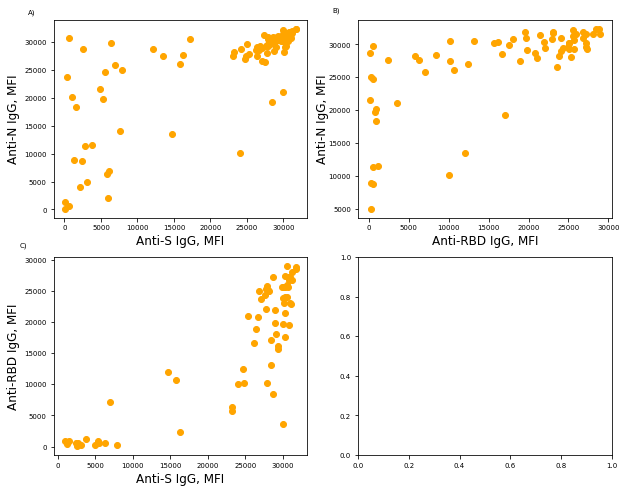

In [63]:
plt.rcParams['figure.figsize'] = [10,8]
plt.rc("font", size=7)
plt.rc("axes", labelsize=12)

pat = covid_ref[covid_ref.status=='patient']

plt.subplot(221)
plt.scatter(pat.s, pat.n, c='orange')
plt.xlabel('Anti-S IgG, MFI')
plt.ylabel('Anti-N IgG, MFI')
plt.text(-5000,35000,"A)")


plt.subplot(222)
plt.scatter(pat.rbd, pat.n, c='orange')
plt.xlabel('Anti-RBD IgG, MFI')
plt.ylabel('Anti-N IgG, MFI', labelpad=0)
plt.text(-4500,35000,"B)")

plt.subplot(223)
plt.scatter(pat.s, pat.rbd, c='orange')
plt.xlabel('Anti-S IgG, MFI')
plt.ylabel('Anti-RBD IgG, MFI')
plt.text(-5000,32000,"C)")

colourmap = ListedColormap(['darkturquoise', 'orange'])
colourmap2 = ListedColormap(['paleturquoise', 'navajowhite'])

#Geneate Z on the original scale
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = scalerb.inverse_transform(scdb)[:, 0].min() - 1000, scalerb.inverse_transform(scdb)[:, 0].max() + 1000
y_min, y_max = scalerb.inverse_transform(scdb)[:, 1].min() - 1000, scalerb.inverse_transform(scdb)[:, 1].max() + 1000
xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max - x_min)/Z.shape[1]),
                     np.arange(y_min, y_max, (y_max - y_min)/Z.shape[0]))
# Z = svmb.predict(np.c_[xx.ravel(), yy.ravel(), np.full(xx.ravel().shape, -0.7)])

# Put the result into a color plot
# Z = Z.reshape(xx.shape)
plt.subplot(224)
# fig = plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=colourmap2)


# Plot also the training points

plt.scatter(staf.s, staf.n, c=col_convert(staf.sero_svm))
# plt.scatter(scaler.inverse_transform(scd)[:, 0], scaler.inverse_transform(scd)[:, 1], c=y, cmap=colourmap)
plt.xlabel('Anti-S IgG, MFI')
plt.ylabel('Anti-N IgG, MFI')
plt.text(-5000,35000,"D)")

plt.savefig("figure_s1_with_boundary.jpg", dpi=300, format="jpg")

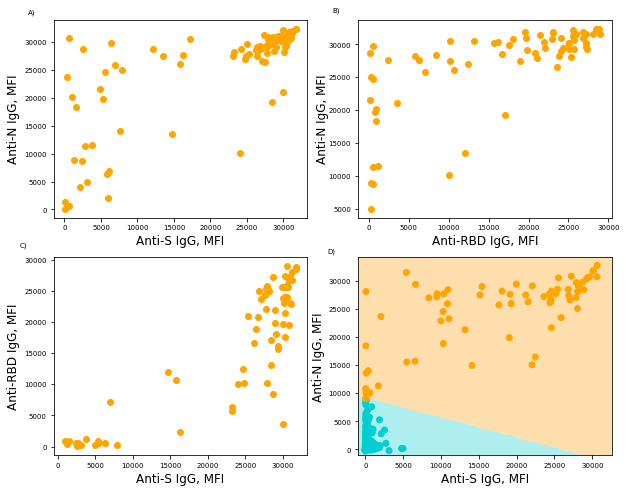

In [91]:
plt.rcParams['figure.figsize'] = [10,8]
plt.rc("font", size=7)
plt.rc("axes", labelsize=12)

pat = covid_ref[covid_ref.status=='patient']

plt.subplot(221)
plt.scatter(pat.s, pat.n, c='orange')
plt.xlabel('Anti-S IgG, MFI')
plt.ylabel('Anti-N IgG, MFI')
plt.text(-5000,35000,"A)")


plt.subplot(222)
plt.scatter(pat.rbd, pat.n, c='orange')
plt.xlabel('Anti-RBD IgG, MFI')
plt.ylabel('Anti-N IgG, MFI', labelpad=0)
plt.text(-4500,35000,"B)")

plt.subplot(223)
plt.scatter(pat.s, pat.rbd, c='orange')
plt.xlabel('Anti-S IgG, MFI')
plt.ylabel('Anti-RBD IgG, MFI')
plt.text(-5000,32000,"C)")

colourmap = ListedColormap(['darkturquoise', 'orange'])
colourmap2 = ListedColormap(['paleturquoise', 'navajowhite'])

#Geneate Z on the original scale
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = scalerb.inverse_transform(scdb)[:, 0].min() - 1000, scalerb.inverse_transform(scdb)[:, 0].max() + 1000
y_min, y_max = scalerb.inverse_transform(scdb)[:, 1].min() - 1000, scalerb.inverse_transform(scdb)[:, 1].max() + 2000
xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max - x_min)/Z.shape[1]),
                     np.arange(y_min, y_max, (y_max - y_min)/Z.shape[0]))

#Uses the Z generated above
# Z = svmb.predict(np.c_[xx.ravel(), yy.ravel(), np.full(xx.ravel().shape, -0.7)])

# Put the result into a color plot
# Z = Z.reshape(xx.shape)
plt.subplot(224)
# fig = plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=colourmap2)


# Plot also staff points

plt.scatter(staf.s, staf.n, c=col_convert(staf.sero_svm))
# plt.scatter(scaler.inverse_transform(scd)[:, 0], scaler.inverse_transform(scd)[:, 1], c=y, cmap=colourmap)
plt.xlabel('Anti-S IgG, MFI')
plt.ylabel('Anti-N IgG, MFI')
plt.text(-5000,35000,"D)")

plt.savefig("figure_s1_with_boundary.jpg", dpi=300, format="jpg")

In [59]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = scd[:, 0].min() - 0.1, scd[:, 0].max() + 0.1
y_min, y_max = scd[:, 1].min() - 0.11, scd[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = svc.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=colourmap2)

NameError: name 'svc' is not defined

In [11]:
# staf = pd.read_csv('staff_svm_demographic_antibodies.csv')

In [33]:
# staf.to_csv('staff_svm_demographic_antibodies.csv', index=False)
# stafsymp.to_csv('staff_svm_demographic_symptoms_antibodies.csv', index=False)

### Linear SVM using N and RBD
When S is dropped it doesn't seem to reduce the accuracy vs just using N and RBD

In [3]:
covid_ref = pd.read_csv("rawdata/covid_pos_neg_reference_samples2.csv")
#remove NAs
covid_ref = covid_ref.dropna(axis=0, subset=['rbd','n'])

In [4]:
# center and scale
scaler = preprocessing.StandardScaler()

#Scaled data
scd = scaler.fit_transform(covid_ref[['rbd','n']])

#Encode status numerically
y = covid_ref.status == 'patient'
y = y.astype(int).values

In [5]:
skf = StratifiedKFold(n_splits=5)

# Indices
indi = []

for train_i, test_i in skf.split(scd, y):
    indi.append((train_i, test_i))

In [6]:
svm = LinearSVC()
svm.fit(scd, y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

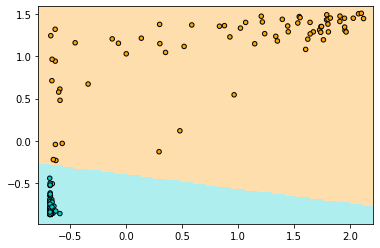

In [7]:
#Step size in the mesh
h=0.02

colourmap = ListedColormap(['darkturquoise', 'orange'])
colourmap2 = ListedColormap(['paleturquoise', 'navajowhite'])

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = scd[:, 0].min() - 0.1, scd[:, 0].max() + 0.1
y_min, y_max = scd[:, 1].min() - 0.11, scd[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=colourmap2)

# Plot also the training points
plt.scatter(scd[:, 0], scd[:, 1], c=y, cmap=colourmap,
            edgecolor='k', s=20)
# plt.xlim(xx.min(), xx.max())
# plt.ylim(yy.min(), yy.max())
# # plt.title("3-Class classification (k = %i, weights = '%s')"
# #           % (n_neighbors, weights))

plt.show()

In [8]:
sensitivity = []
specificity = []

# Cross validation
for i in indi:
    mod = LinearSVC()
    mod.fit(scd[i[0]], y[i[0]])

    # prediction is true positive
    tp = np.sum((mod.predict(scd[i[1]]) == y[i[1]]) & (mod.predict(scd[i[1]]) == 1))
    #False negatives
    fn = np.sum((mod.predict(scd[i[1]]) != y[i[1]]) & (mod.predict(scd[i[1]]) == 0))

    # prediction is true negative
    tn = np.sum((mod.predict(scd[i[1]]) == y[i[1]]) & (mod.predict(scd[i[1]]) == 0))
    #False positives
    fp = np.sum((mod.predict(scd[i[1]]) != y[i[1]]) & (mod.predict(scd[i[1]]) == 1))

    sensitivity.append(tp/(tp+fn))
    specificity.append(tn/(tn+fp))
    
#     print(mod.score(scd[i[1]], y[i[1]]))

    
print(np.mean(specificity))
print(np.mean(sensitivity))

1.0
0.9714285714285715
